<a href="https://colab.research.google.com/github/ohnownihs/NLP/blob/master/Learning_Spoons_5%EA%B0%95_(%EA%B0%9C%EC%B2%B4%EB%AA%85_%EC%9D%B8%EC%8B%9D)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CRF와 ELMo의 쉽고 원활한 사용을 위해 버전을 낮춤
%tensorflow_version 1.x
!pip install keras==2.2.4

TensorFlow 1.x selected.
     |████████████████████████████████| 317kB 2.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
# CRF layer 설치
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-7h94cle6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-7h94cle6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=3d9ca8e6a20bb9757f5229d865ed9ec063e8683a23bdf7c82d608ff5b1b83c14
  Stored in directory: /tmp/pip-ephem-wheel-cache-mrzf1zup/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
# 모델 평가
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=493f26502658b5ecaa3f1ace841936ceb44e829e5abfb852cbc1e2bab06daf55
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


ner_dataset.csv를 Colab에 업로드하세요.

# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))


데이터에 Null 값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


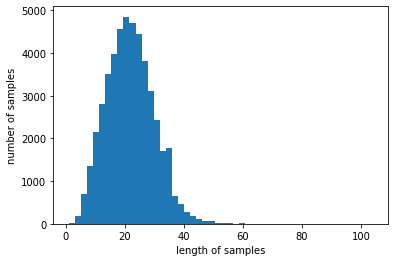

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM-CNN을 위한 추가 전처리

In [ ]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
print(chars)

{'&', '\x92', '~', '(', '!', 'b', '6', 'k', 'z', '\x96', 'é', '+', 'e', 'l', '3', '0', ',', '4', 'ö', '`', 'g', 'v', 's', ':', '2', '$', 'd', '@', 't', 'r', 'f', 'u', 'y', '\x97', 'c', 'w', 'a', '#', '9', '1', '\xa0', '[', '-', 'j', 'o', '.', '°', '\x91', 'p', '5', '8', '\x93', 'x', "'", 'q', '\x94', '"', '_', '\x85', ';', '7', 'h', '/', 'ü', 'n', 'i', ')', ']', 'm', '%', '?', 'ë'}


In [ ]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [ ]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [ ]:
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
  max_len_char = 15

  def padding_char_indice(char_indice, max_len_char):
      return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', 
        value = 0)
    
  def integer_coding(sentences):
      char_data = []
      for ts in sentences:
        word_indice = [word_to_index[t] for t in ts]
        char_indice = [[char_to_index[char] for char in t]  
                                                     for t in ts]
        char_indice = padding_char_indice(char_indice, max_len_char)
    
        for chars_of_token in char_indice:
            if len(chars_of_token) > max_len_char:
                print("최대 단어 길이 초과!")
                continue
        char_data.append(char_indice)
      return char_data

In [ ]:
X_char_data = integer_coding(sentences)

In [ ]:
print(X_data[0])

[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(X_char_data[0])

[[30 63 46 33 24 38 66 28 24  0  0  0  0  0  0]
 [46 32  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [28 14 70 46 66 24 30 31 38 30 46 31 24  0  0]
 [63 38 23 14  0  0  0  0  0  0  0  0  0  0  0]
 [70 38 31 36 63 14 28  0  0  0  0  0  0  0  0]
 [30 63 31 46 33 22 63  0  0  0  0  0  0  0  0]
 [15 46 66 28 46 66  0  0  0  0  0  0  0  0  0]
 [30 46  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [50 31 46 30 14 24 30  0  0  0  0  0  0  0  0]
 [30 63 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 31  0  0  0  0  0  0  0  0  0  0  0  0]
 [67 66  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [67 31 38 56  0  0  0  0  0  0  0  0  0  0  0]
 [38 66 28  0  0  0  0  0  0  0  0  0  0  0  0]
 [28 14 70 38 66 28  0  0  0  0  0  0  0  0  0]
 [30 63 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 67 30 63 28 31 38 37 38 15  0  0  0  0  0]
 [46 32  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7 31 67 30 67 24 63  0  0  0  0  0  0  0  0]
 [30 31 46 46 50 24  0  0  0  0  0  0  0  0  0]
 [32 31 46 70  0  0  0  0  0  0  0  0  0

In [ ]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

In [ ]:
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [ ]:
print(X_train[0])

[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(index_to_word[150])

soldiers


In [ ]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM-CNN을 이용한 개체명인식

In [ ]:
from keras.layers import Embedding, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from keras import Input, Model
from keras.initializers import RandomUniform

Using TensorFlow backend.


In [ ]:
# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim = vocab_size, output_dim = 64)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(50, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['accuracy'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 15)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 15, 30) 2220        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 15, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 15, 30) 2730        dropout_1[0][0]      

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size = 128, epochs = 3, validation_split = 0.1, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 34530 samples, validate on 3837 samples
Epoch 1/3





34530/34530 [==============================] - 87s 3ms/step - loss: 0.2439 - acc: 0.9419 - val_loss: 0.0843 - val_acc: 0.9781
Epoch 2/3
34530/34530 [==============================] - 73s 2ms/step - loss: 0.0632 - acc: 0.9830 - val_loss: 0.0524 - val_acc: 0.9850
Epoch 3/3
34530/34530 [==============================] - 71s 2ms/step - loss: 0.0445 - acc: 0.9873 - val_loss: 0.0461 - val_acc: 0.9864


In [ ]:
model.save('bilstm_cnn.h5')

In [ ]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict([[X_test[i]], [X_char_test[i]]]) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


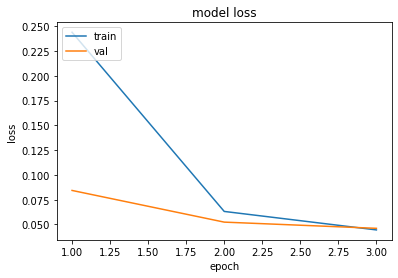

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(test_tags, pred_tags))

           precision    recall  f1-score   support

      org       0.54      0.52      0.53      4033
      tim       0.79      0.81      0.80      4067
      geo       0.78      0.85      0.81      7620
      per       0.72      0.69      0.71      3545
      gpe       0.93      0.94      0.93      3145
      art       0.00      0.00      0.00        63
      nat       0.00      0.00      0.00        37
      eve       0.00      0.00      0.00        52

micro avg       0.75      0.77      0.76     22562
macro avg       0.74      0.77      0.75     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 75.9%


# BiLSTM-CRF를 이용한 개체명인식

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 20)            636380    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 100)           28400     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 70, 18)            1278      
Total params: 671,108
Trainable params: 671,108
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size = 128, epochs=5, validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Train on 34530 samples, validate on 3837 samples
Epoch 1/5
34530/34530 [==============================] - 88s 3ms/step - loss: 8.6186 - crf_viterbi_accuracy: 0.8433 - val_loss: 8.3303 - val_crf_viterbi_accuracy: 0.8912
Epoch 2/5
34530/34530 [==============================] - 83s 2ms/step - loss: 8.2678 - crf_viterbi_accuracy: 0.9140 - val_loss: 8.2074 - val_crf_viterbi_accuracy: 0.9300
Epoch 3/5
34530/34530 [==============================] - 84s 2ms/step - loss: 8.1605 - crf_viterbi_accuracy: 0.9444 - val_loss: 8.1330 - val_crf_viterbi_accuracy: 0.9473
Epoch 4/5
34530/34530 [==============================] - 84s 2ms/step - loss: 8.1174 - crf_viterbi_accuracy: 0.9551 - val_loss: 8.1139 - val_crf_viterbi_accuracy: 0.9496
Epoch 5/5
34530/34530 [==============================] - 84s 2ms/step - loss: 8.0978 - crf_viterbi_accuracy: 0.9598 - val_loss: 8.0969 - val_crf_viterbi_accuracy: 0.9556


In [ ]:
model.save('bilstm_crf.h5')

In [ ]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


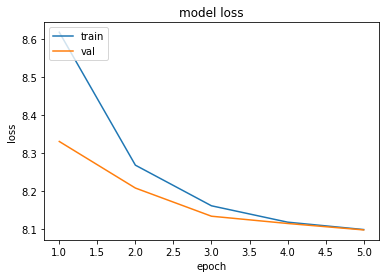

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
y_predicted = model.predict(X_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(test_tags, pred_tags))

           precision    recall  f1-score   support

      tim       0.89      0.81      0.84      4067
      per       0.76      0.76      0.76      3545
      geo       0.82      0.84      0.83      7620
      org       0.70      0.47      0.56      4033
      gpe       0.96      0.93      0.94      3145
      eve       0.00      0.00      0.00        52
      nat       0.00      0.00      0.00        37
      art       0.00      0.00      0.00        63

micro avg       0.83      0.76      0.79     22562
macro avg       0.82      0.76      0.79     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.4%


In [ ]:
new_sentence='Hong Gildong starts over with the Justice League of Joseon at the country of Yul'.split()

In [ ]:
new_X=[]
for w in new_sentence:
    try:
      new_X.append(word_to_index.get(w,1))
    except KeyError:
      new_X.append(word_to_index['OOV'])
      # 모델이 모르는 단어에 대해서는 'OOV'의 인덱스인 1로 인코딩

print(new_X)

[1, 1, 4027, 80, 17, 2, 1, 1, 6, 1, 20, 2, 56, 6, 1]


In [ ]:
pad_new = pad_sequences([new_X], padding="post", value=0, maxlen=max_len)

In [ ]:
p = model.predict(np.array([pad_new[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("단어", "예측값"))
print(30 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:15}: {:5}".format(w, index_to_ner[pred]))

단어             ||예측값
Hong           : B-per
Gildong        : I-per
starts         : O    
over           : O    
with           : O    
the            : O    
Justice        : B-org
League         : I-org
of             : I-org
Joseon         : I-org
at             : O    
the            : O    
country        : O    
of             : O    
Yul            : B-geo


# ELMo를 위한 추가 전처리

In [ ]:
print(sentences[100])

['she', 'was', 'a', 'longtime', 'member', 'of', 'the', 'zapatista', 'movement', 'and', 'appeared', 'in', 'public', 'wearing', 'a', 'black', 'ski', 'mask', '.']


In [ ]:
print(ner_tags[100])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
batch_size = 32

In [ ]:
new_X = []
for seq in sentences:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_data_for_elmo = new_X

In [ ]:
print(X_data_for_elmo[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__']


In [ ]:
print(np.shape(X_data_for_elmo))

(47959, 70)


In [ ]:
y_data_for_elmo = [[ner_to_index[tag] for tag in sample] for sample in ner_tags]

In [ ]:
y_data_for_elmo = pad_sequences(y_data_for_elmo, padding='post', maxlen=max_len)

In [ ]:
print(y_data_for_elmo[0])

[1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 8 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(np.shape(y_data_for_elmo))

(47959, 70)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_for_elmo, X_test_for_elmo, y_train_for_elmo, y_test_for_elmo = train_test_split(X_data_for_elmo, y_data_for_elmo, test_size=.2, random_state=777)

In [ ]:
X_train_for_elmo = np.asarray(X_train_for_elmo)
X_test_for_elmo = np.asarray(X_test_for_elmo)
y_train_for_elmo = np.asarray(y_train_for_elmo)
y_test_for_elmo = np.asarray(y_test_for_elmo)

In [ ]:
y_train_for_elmo = to_categorical(y_train_for_elmo) # 원-핫 인코딩
y_test_for_elmo = to_categorical(y_test_for_elmo) # 원-핫 인코딩

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(np.shape(X_train_for_elmo)))
print('훈련 샘플 레이블의 크기 : {}'.format(np.shape(y_train_for_elmo)))
print('테스트 샘플 문장의 크기 : {}'.format(np.shape(X_test_for_elmo)))
print('테스트 샘플 레이블의 크기 : {}'.format(np.shape(y_test_for_elmo)))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


In [ ]:
38367/batch_size

1198.96875

In [ ]:
n_of_train = batch_size * 1078
print(n_of_train)

34496


In [ ]:
n_of_val = batch_size * 120
print(n_of_val)

3840


In [ ]:
X_train_for_elmo, X_val_for_elmo = X_train_for_elmo[:n_of_train], X_train_for_elmo[-n_of_val:]
y_train_for_elmo, y_val_for_elmo = y_train_for_elmo[:n_of_train], y_train_for_elmo[-n_of_val:]

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(np.shape(X_train_for_elmo)))
print('훈련 샘플 레이블의 크기 : {}'.format(np.shape(y_train_for_elmo)))
print('검증 샘플 문장의 크기 : {}'.format(np.shape(X_val_for_elmo)))
print('검증 샘플 레이블의 크기 : {}'.format(np.shape(y_val_for_elmo)))
print('테스트 샘플 문장의 크기 : {}'.format(np.shape(X_test_for_elmo)))
print('테스트 샘플 레이블의 크기 : {}'.format(np.shape(y_test_for_elmo)))

훈련 샘플 문장의 크기 : (34496, 70)
훈련 샘플 레이블의 크기 : (34496, 70, 18)
검증 샘플 문장의 크기 : (3840, 70)
검증 샘플 레이블의 크기 : (3840, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# ELMo를 이용한 개체명인식

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
sess = tf.Session()
K.set_session(sess)

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
tag_size

18

In [ ]:
# LSTM의 입력으로 사용해야하므로 3차원 텐서로 만들어주어야 한다.
def ELMoEmbedding(x):
    return elmo(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(None, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # 레지듀얼 커넥션
out = TimeDistributed(Dense(tag_size, activation="softmax"))(x)
model = Model(input_text, out)
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_for_elmo, y_train_for_elmo, validation_data=(X_val_for_elmo, y_val_for_elmo), batch_size = 128, epochs = 5, verbose=1)

Train on 34496 samples, validate on 3840 samples
Epoch 1/5
34496/34496 [==============================] - 559s 16ms/step - loss: 0.0585 - acc: 0.9828 - val_loss: 0.0398 - val_acc: 0.9874
Epoch 2/5
34496/34496 [==============================] - 552s 16ms/step - loss: 0.0359 - acc: 0.9885 - val_loss: 0.0365 - val_acc: 0.9883
Epoch 3/5
12640/34496 [=========>....................] - ETA: 5:26 - loss: 0.0288 - acc: 0.9905

KeyboardInterrupt: ignored

In [ ]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array(X_test_for_elmo[i:i+batch_size]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test_for_elmo[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test_for_elmo[i], true, y_predicted):
    if w != '__PAD__': # PAD값은 제외함.
        print("{:17}: {:7} {}".format(w, index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O
